In [1]:
import pandas as pd
import glob

# 1. Gather file paths
#   Matches any file named like “MBTA-Bus-Arrival-Departure-Times_2024-01.csv” etc.
csv_files = glob.glob("/Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-*.csv")

all_dataframes = []

for file_path in csv_files:
    print(f"Loading {file_path}...")
    df_temp = pd.read_csv(file_path)
    
    # Example cleaning: convert service_date
    if 'service_date' in df_temp.columns:
        df_temp['service_date'] = pd.to_datetime(df_temp['service_date'], errors='coerce')
    
    # Example cleaning: convert scheduled/actual to time objects
    if 'scheduled' in df_temp.columns and 'actual' in df_temp.columns:
        df_temp['scheduled_time'] = pd.to_datetime(df_temp['scheduled'], errors='coerce').dt.time
        df_temp['actual_time'] = pd.to_datetime(df_temp['actual'], errors='coerce').dt.time

    
    all_dataframes.append(df_temp)

# 2. Merge all into one DataFrame
df_merged = pd.concat(all_dataframes, ignore_index=True)

# 3. Inspect merged data
df_merged.info()
df_merged.head()


Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-09.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-08.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-01.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-03.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-02.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-12.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-06.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-07.csv...
Loading /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arri

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,scheduled_time,actual_time
0,2024-09-01,01,Inbound,64240110.0,110,hhgat,1,Startpoint,Schedule,1900-01-01T11:05:00Z,1900-01-01T11:05:21Z,NaN,NaN,11:05:00,11:05:21
1,2024-09-01,01,Inbound,64240110.0,67,maput,2,Midpoint,Schedule,1900-01-01T11:09:00Z,1900-01-01T11:06:57Z,NaN,NaN,11:09:00,11:06:57
2,2024-09-01,01,Inbound,64240110.0,72,cntsq,3,Midpoint,Schedule,1900-01-01T11:12:00Z,1900-01-01T11:09:43Z,NaN,NaN,11:12:00,11:09:43
3,2024-09-01,01,Inbound,64240110.0,75,mit,4,Midpoint,Schedule,1900-01-01T11:15:00Z,1900-01-01T11:14:13Z,NaN,NaN,11:15:00,11:14:13
4,2024-09-01,01,Inbound,64240110.0,79,hynes,5,Midpoint,Schedule,1900-01-01T11:19:00Z,1900-01-01T11:17:53Z,NaN,NaN,11:19:00,11:17:53


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def time_to_minutes(t):
    """Convert a datetime.time object to minutes since midnight."""
    if pd.isnull(t):
        return np.nan
    return t.hour * 60 + t.minute + t.second / 60.0

df_merged['scheduled_minutes'] = df_merged['scheduled_time'].apply(time_to_minutes)
df_merged['actual_minutes'] = df_merged['actual_time'].apply(time_to_minutes)



In [3]:
#Calculate DELAYS
df_merged['delay_minutes'] = df_merged['actual_minutes'] - df_merged['scheduled_minutes']

# Quick look
df_merged[['service_date','route_id','scheduled_time','actual_time','delay_minutes']].head(10)


,service_date,route_id,scheduled_time,actual_time,delay_minutes
0,2024-09-01,01,11:05:00,11:05:21,0.350000
1,2024-09-01,01,11:09:00,11:06:57,-2.050000
2,2024-09-01,01,11:12:00,11:09:43,-2.283333
3,2024-09-01,01,11:15:00,11:14:13,-0.783333
4,2024-09-01,01,11:19:00,11:17:53,-1.116667
5,2024-09-01,01,11:21:00,11:22:56,1.933333
6,2024-09-01,01,11:25:00,11:27:15,2.250000
7,2024-09-01,01,11:25:00,11:24:58,-0.033333
8,2024-09-01,01,11:29:00,11:27:02,-1.966667
9,2024-09-01,01,11:29:00,11:31:34,2.566667


In [4]:
# Filter the rows that are start vs. end
df_start = df_merged[df_merged['point_type'] == 'Starting'].copy()
df_end   = df_merged[df_merged['point_type'] == 'Endpoint'].copy()


In [5]:
df_trip = pd.merge(
    df_start,
    df_end,
    on=['route_id','half_trip_id'],  # add direction_id here if needed
    suffixes=('_start','_end')
)

# df_trip now has columns from both start & end. Quick look:
df_trip.head()


,service_date_start,route_id,direction_id_start,half_trip_id,stop_id_start,time_point_id_start,time_point_order_start,point_type_start,standard_type_start,scheduled_start,...,standard_type_end,scheduled_end,actual_end,scheduled_headway_end,headway_end,scheduled_time_end,actual_time_end,scheduled_minutes_end,actual_minutes_end,delay_minutes_end


In [6]:
df_trip['travel_time_start'] = df_trip['actual_minutes_start']
df_trip['travel_time_end']   = df_trip['actual_minutes_end']

# Actual run time (end - start)
df_trip['actual_travel_time'] = df_trip['travel_time_end'] - df_trip['travel_time_start']

# Quick stats
df_trip['actual_travel_time'].describe()


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: actual_travel_time, dtype: float64

In [7]:
end_to_end_by_route = df_trip.groupby('route_id')['actual_travel_time'].mean().reset_index()
end_to_end_by_route.rename(columns={'actual_travel_time':'avg_travel_time'}, inplace=True)
end_to_end_by_route.sort_values('avg_travel_time', inplace=True)
end_to_end_by_route.head(10)


,route_id,avg_travel_time


In [8]:
df_merged['delayed_flag'] = df_merged['delay_minutes'] > 5  # or 5, 10, etc.
df_merged['delayed_flag'].value_counts(dropna=False)


delayed_flag
False    18483937
True      8565266
Name: count, dtype: int64

In [9]:
avg_delay_citywide = df_merged['delay_minutes'].mean()
print(f"Average Delay Across All Routes: {avg_delay_citywide:.2f} minutes")


Average Delay Across All Routes: -0.76 minutes


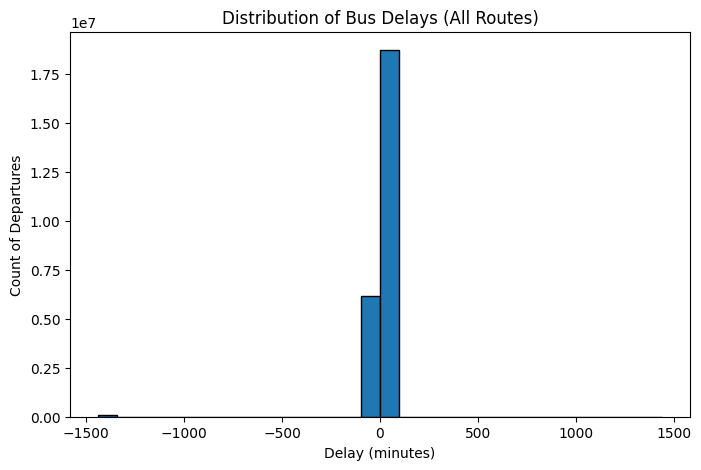

In [10]:
plt.figure(figsize=(8,5))
plt.hist(df_merged['delay_minutes'].dropna(), bins=30, edgecolor='black')
plt.xlabel("Delay (minutes)")
plt.ylabel("Count of Departures")
plt.title("Distribution of Bus Delays (All Routes)")
plt.show()


In [11]:
target_routes = [22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14]

# route_id might be string or int—convert as needed
df_merged['route_id_str'] = df_merged['route_id'].astype(str)
target_str = [str(r) for r in target_routes]

df_target = df_merged[df_merged['route_id_str'].isin(target_str)].copy()


In [12]:
avg_delay_targets = df_target['delay_minutes'].mean()
print(f"Average Delay (Target Routes): {avg_delay_targets:.2f} minutes")


Average Delay (Target Routes): -1.19 minutes


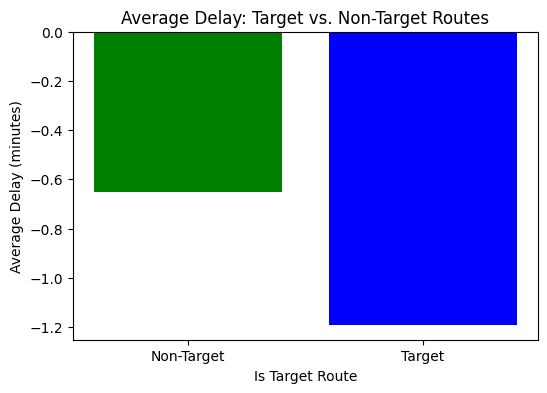

In [13]:
df_merged['is_target'] = df_merged['route_id_str'].isin(target_str)
mean_delay = df_merged.groupby('is_target')['delay_minutes'].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(mean_delay['is_target'].astype(str), mean_delay['delay_minutes'], color=['green','blue'])
plt.xlabel("Is Target Route")
plt.ylabel("Average Delay (minutes)")
plt.title("Average Delay: Target vs. Non-Target Routes")
plt.xticks([0,1], labels=["Non-Target","Target"])
plt.show()


In [14]:
avg_delay_by_route = df_merged.groupby('route_id_str')['delay_minutes'].mean().reset_index()
avg_delay_by_route.rename(columns={'delay_minutes':'avg_delay'}, inplace=True)
avg_delay_by_route.sort_values('avg_delay', ascending=False, inplace=True)
avg_delay_by_route.head()


,route_id_str,avg_delay
111,600,10.439897
17,114,6.350690
36,193,5.843909
95,456,4.241081
39,202,3.995497


In [15]:
late_pct_by_route = (
    df_merged.groupby('route_id_str')['delayed_flag']
    .mean()  # mean of True/False -> fraction True
    .reset_index(name='late_pct')
)
late_pct_by_route['late_pct'] = late_pct_by_route['late_pct'] * 100.0
late_pct_by_route.sort_values('late_pct', ascending=False, inplace=True)
late_pct_by_route.head()


,route_id_str,late_pct
146,CT2,53.649794
60,29,52.162338
57,245,51.423778
88,44,48.394730
96,47,48.218204


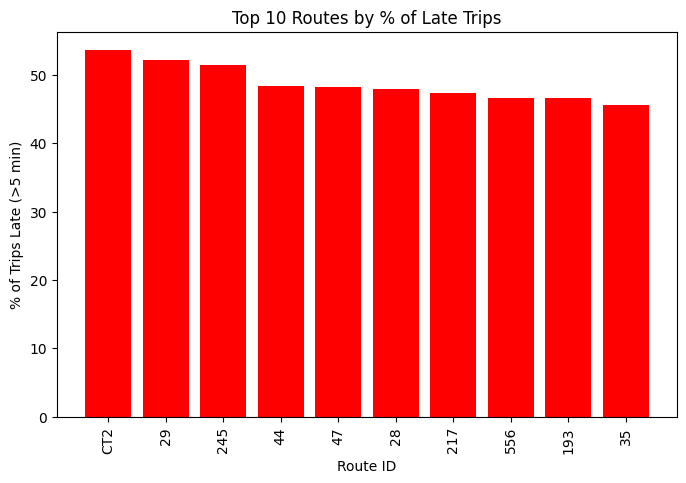

In [16]:
top10_late = late_pct_by_route.head(10)  # top 10

plt.figure(figsize=(8,5))
plt.bar(top10_late['route_id_str'], top10_late['late_pct'], color='red')
plt.xlabel("Route ID")
plt.ylabel("% of Trips Late (>5 min)")
plt.title("Top 10 Routes by % of Late Trips")
plt.xticks(rotation=90)
plt.show()


In [17]:
output_path = "/Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA_Bus_2024_Preprocessed.csv"
df_merged.to_csv(output_path, index=False)
print(f"Preprocessed data saved to {output_path}")


Preprocessed data saved to /Users/chris/Desktop/MBTA_Bus_Arrival_Departure_Times_2024/MBTA_Bus_2024_Preprocessed.csv


In [18]:
# 1. Create a flag for on-time vs. late
df_merged['on_time_flag'] = df_merged['delay_minutes'] <= 5

# 2. Extract day of week from service_date
df_merged['day_of_week'] = df_merged['service_date'].dt.dayofweek

# 3. Aggregate by route + date (one row per route-day)
daily = df_merged.groupby(['route_id_str', 'service_date'], as_index=False).agg({
    'on_time_flag': 'mean',
    'delay_minutes': 'mean',
    'day_of_week': 'first'
})
daily.rename(columns={'on_time_flag': 'on_time_pct'}, inplace=True)

# 4. Encode route as a categorical variable
daily['route_cat'] = daily['route_id_str'].astype('category').cat.codes

# 5. Split into features (X) and target (y)
X = daily[['route_cat', 'day_of_week', 'delay_minutes']]
y = daily['on_time_pct']

# 6. Train/test split (random for demo; you could do a time-based split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Choose a model (RandomForestRegressor as example)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 8. Predict on the test set
y_pred = model.predict(X_test)

# 9. Evaluate
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("RandomForest Regressor:")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")


RandomForest Regressor:
RMSE: 0.111
R^2:  0.565


/Users/chris/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------------------------------------------
# 0. Assume df_merged already loaded/cleaned:
#    - Includes columns: service_date (datetime), route_id_str, delay_minutes
#    - If not, read your CSV or do the merges first, then run:
#        df_merged['route_id_str'] = df_merged['route_id'].astype(str)
# -----------------------------------------------------------------

# 1) Define on_time_flag and year_month columns
df_merged['on_time_flag'] = df_merged['delay_minutes'] <= 5
df_merged['year_month'] = df_merged['service_date'].dt.to_period('M')  # e.g. 2024-01, 2024-02, etc.
df_merged['day_of_week'] = df_merged['service_date'].dt.dayofweek

# 2) Split: Train on Jan–Aug 2024, Predict on Sept 2024
train_mask = (df_merged['year_month'] >= '2024-01') & (df_merged['year_month'] <= '2024-08')
test_mask  = (df_merged['year_month'] == '2024-09')

df_train = df_merged[train_mask].copy()
df_test  = df_merged[test_mask].copy()

# 3) Aggregate each subset to daily route-level
def aggregate_daily_route(df):
    daily = df.groupby(['route_id_str','service_date'], as_index=False).agg({
        'on_time_flag': 'mean',
        'delay_minutes': 'mean',
        'day_of_week': 'first'
    })
    daily.rename(columns={'on_time_flag':'on_time_pct'}, inplace=True)
    daily['route_cat'] = daily['route_id_str'].astype('category').cat.codes
    return daily

daily_train = aggregate_daily_route(df_train)
daily_test  = aggregate_daily_route(df_test)

# 4) Prepare features (X) and target (y) for training
#    Here: X = route_cat, day_of_week, daily mean delay
X_train = daily_train[['route_cat','day_of_week','delay_minutes']]
y_train = daily_train['on_time_pct']

# 5) Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6) Predict for SEPT 2024
X_test = daily_test[['route_cat','day_of_week','delay_minutes']]
y_pred = model.predict(X_test)

# Store predictions in daily_test
daily_test['predicted_on_time_pct'] = y_pred

# 7) Optional: If you DO have real data for September, you can evaluate
if 'on_time_pct' in daily_test.columns:
    # Evaluate if actual data is present
    y_true = daily_test['on_time_pct']
    if not y_true.isna().all():
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2   = r2_score(y_true, y_pred)
        print("Evaluation on September 2024 (Time-Based):")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  R^2:  {r2:.3f}")
    else:
        print("No ground truth for September—just predictions.")
else:
    print("No on_time_pct column in daily_test to compare—just predictions.")

# 8) Present the results
print("\n----- SAMPLES OF PREDICTIONS FOR SEPT 2024 -----")
display(daily_test[['route_id_str','service_date','predicted_on_time_pct']].head(20))

# (Optional) Group by route for a final average
route_preds = daily_test.groupby('route_id_str', as_index=False)['predicted_on_time_pct'].mean()
route_preds.sort_values('predicted_on_time_pct', ascending=False, inplace=True)

print("\n----- AVERAGE PREDICTED ON-TIME % BY ROUTE (SEPT 2024) -----")
display(route_preds.head(20))


Evaluation on September 2024 (Time-Based):
  RMSE: 0.132
  R^2:  0.307

----- SAMPLES OF PREDICTIONS FOR SEPT 2024 -----


/Users/chris/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,route_id_str,service_date,predicted_on_time_pct
0,01,2024-09-01,0.795503
1,01,2024-09-02,0.486686
2,01,2024-09-03,0.424320
3,01,2024-09-04,0.428193
4,01,2024-09-05,0.302507
5,01,2024-09-06,0.331868
6,01,2024-09-07,0.612485
7,01,2024-09-08,0.532394
8,01,2024-09-09,0.412598
9,01,2024-09-10,0.391647



----- AVERAGE PREDICTED ON-TIME % BY ROUTE (SEPT 2024) -----


,route_id_str,predicted_on_time_pct
37,194,0.869316
35,192,0.806786
103,55,0.782503
22,121,0.777363
119,69,0.772478
118,68,0.759508
50,226,0.751792
121,71,0.746434
132,85,0.744888
141,94,0.741892


In [21]:
# 1) Ensure your df_merged has a datetime column 'service_date' and a route_id_str, 
#    plus an on_time_flag or on_time_pct column. 
#    For example:
#       df_merged['on_time_flag'] = df_merged['delay_minutes'] <= 5
#       df_merged['service_date'] = pd.to_datetime(df_merged['service_date'], errors='coerce')
#       df_merged['route_id_str'] = df_merged['route_id'].astype(str)

# 2) Create a 'year_month' column (period), then filter for September 2024:
df_merged['year_month'] = df_merged['service_date'].dt.to_period('M')
sept_mask = (df_merged['year_month'] == '2024-09')
df_sept = df_merged[sept_mask].copy()

# 3) Aggregate by route + date to compute daily on_time_pct
#    If you haven't already computed on_time_flag, do so:
df_sept['on_time_flag'] = df_sept['delay_minutes'] <= 5

daily_sept = df_sept.groupby(['route_id_str','service_date'], as_index=False).agg({
    'on_time_flag': 'mean'
})
daily_sept.rename(columns={'on_time_flag':'on_time_pct'}, inplace=True)

# 4) Now compute average on-time percentage by route across all of September 2024
route_actuals = (
    daily_sept
    .groupby('route_id_str', as_index=False)['on_time_pct']
    .mean()
)

route_actuals.rename(columns={'on_time_pct': 'avg_on_time_pct'}, inplace=True)
route_actuals.sort_values('avg_on_time_pct', ascending=False, inplace=True)

print("----- AVERAGE ON-TIME % BY ROUTE (SEPT 2024) -----")
display(route_actuals.head(20))


----- AVERAGE ON-TIME % BY ROUTE (SEPT 2024) -----


,route_id_str,avg_on_time_pct
37,194,0.879167
69,351,0.846226
35,192,0.817130
22,121,0.815190
103,55,0.803509
118,68,0.772059
112,61,0.767151
50,226,0.765890
117,67,0.765365
132,85,0.756790
